In [1]:
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задание

* Убедиться в нестабильности одиночного дерева на своих данных
* Отобрать самые важные признаки случайным лесом, сравнить результат с отбором признаков линейным методом с L_1L -регуляризацией
* Сравнить качество работы случайного леса без кросс-валидации с кросс-валидацией
* Сравнить качество работы и время обучения  (%%time в начале ячейки) леса с градиентным бустингом над решающими деревьями, при подобрав для каждого оптимальные параметры. Особо хорошо будет, если градиентный бустинг обучите на видеокарте

In [2]:
raw_data = pd.read_csv("Pokemon.csv",index_col = 1)
raw_data.drop("#",axis = 1,inplace = True)

In [3]:
types = raw_data["Type 2"].value_counts().index

raw_data["No second type"] = raw_data["Type 2"].apply(lambda x: 1 if pd.isnull(x) else 0)

for pokemon_type in types:
    raw_data[pokemon_type] = raw_data["Type 1"].apply(lambda x: 1 if x == pokemon_type else 0)
    raw_data.loc[raw_data["Type 2"] == pokemon_type,pokemon_type] = raw_data.loc[raw_data["Type 2"] == pokemon_type,
                                                                                 pokemon_type].apply(lambda x: 1)
raw_data["Legendary"] = raw_data["Legendary"].apply(lambda x: 1 if x  else 0)

In [4]:
Legendary = raw_data["Legendary"]
raw_data = raw_data.drop("Legendary",axis = 1)
raw_data["Legendary"] = Legendary

raw_data = raw_data.drop(["Type 1","Type 2"],axis = 1)

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

raw_data = shuffle(raw_data,random_state = 0)

Train_source,Test_source,y_train,y_test = train_test_split(raw_data.drop("Legendary",axis = 1),raw_data["Legendary"],
                                   test_size = 0.33,stratify = raw_data["Legendary"],random_state = 0)

In [6]:
X_train = Train_source
X_test = Test_source

### Убедиться в нестабильности одиночного дерева на своих данных

* алгоритм называют нестабильным,если он обладает высокой чувствительностью к входным данным
* добавим всего лишь один элемент в обучающую выборку

In [7]:
from sklearn import tree

In [8]:
X_train_ext = pd.concat([X_train,X_test.loc[y_test == 1][:1]],axis = 0)
y_train_ext = np.hstack((y_train,[1]))

X_test_ext = X_test.copy()
y_test_ext = y_test.copy()

X_test_ext.drop(X_test_ext.loc[y_test_ext == 1][:1].index[0],inplace = True)
y_test_ext.drop(labels = [X_test_ext.loc[y_test_ext == 1][:1].index[0]],inplace = True)

In [9]:
print "Количество элементов до: ",len(X_train)
print "Количество элементов после:",len(X_train_ext)

Количество элементов до:  536
Количество элементов после: 537


In [10]:
tree_clf = tree.DecisionTreeClassifier(random_state = 1)
tree_clf.fit(X_train,y_train)
print "Качество до :",tree_clf.score(X_test,y_test)

tree_clf_ext = tree.DecisionTreeClassifier(random_state = 1)
tree_clf_ext.fit(X_train_ext,y_train_ext)
print "Качество после :",tree_clf_ext.score(X_test_ext,y_test_ext)

Качество до : 0.9621212121212122
Качество после : 0.9543726235741445


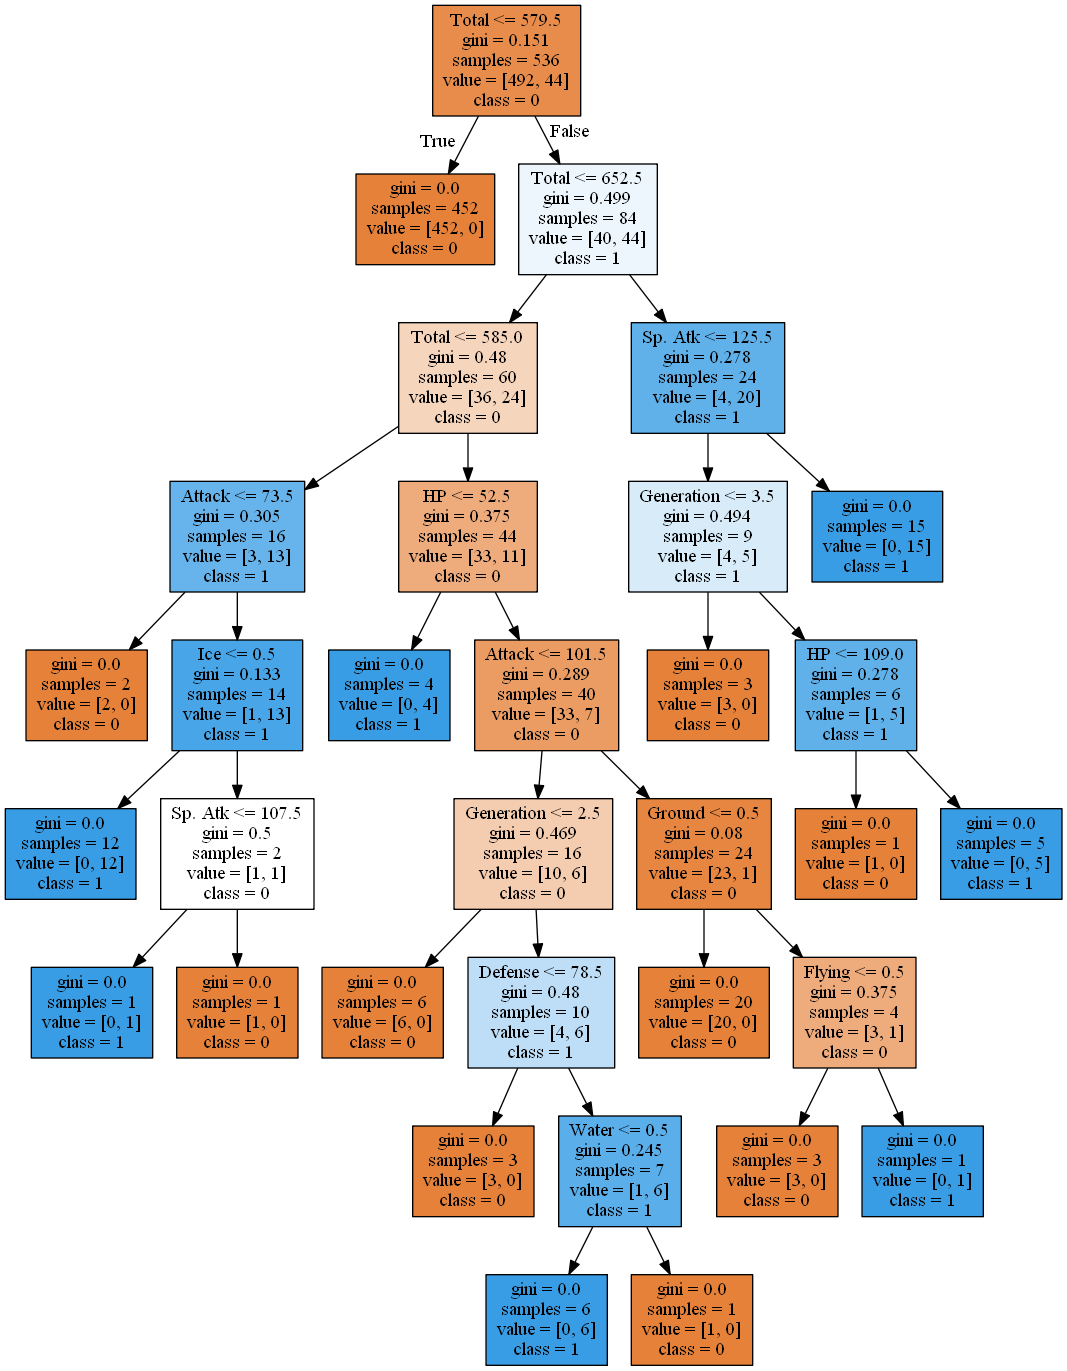

In [11]:
from sklearn.tree import export_graphviz
# Export as dot file
from graphviz import Source

graph = Source( tree.export_graphviz(tree_clf, out_file=None, feature_names=X_train.columns,class_names=['0', '1'],
                                    filled = True))
png_bytes = graph.pipe(format='png')
with open('first_tree.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

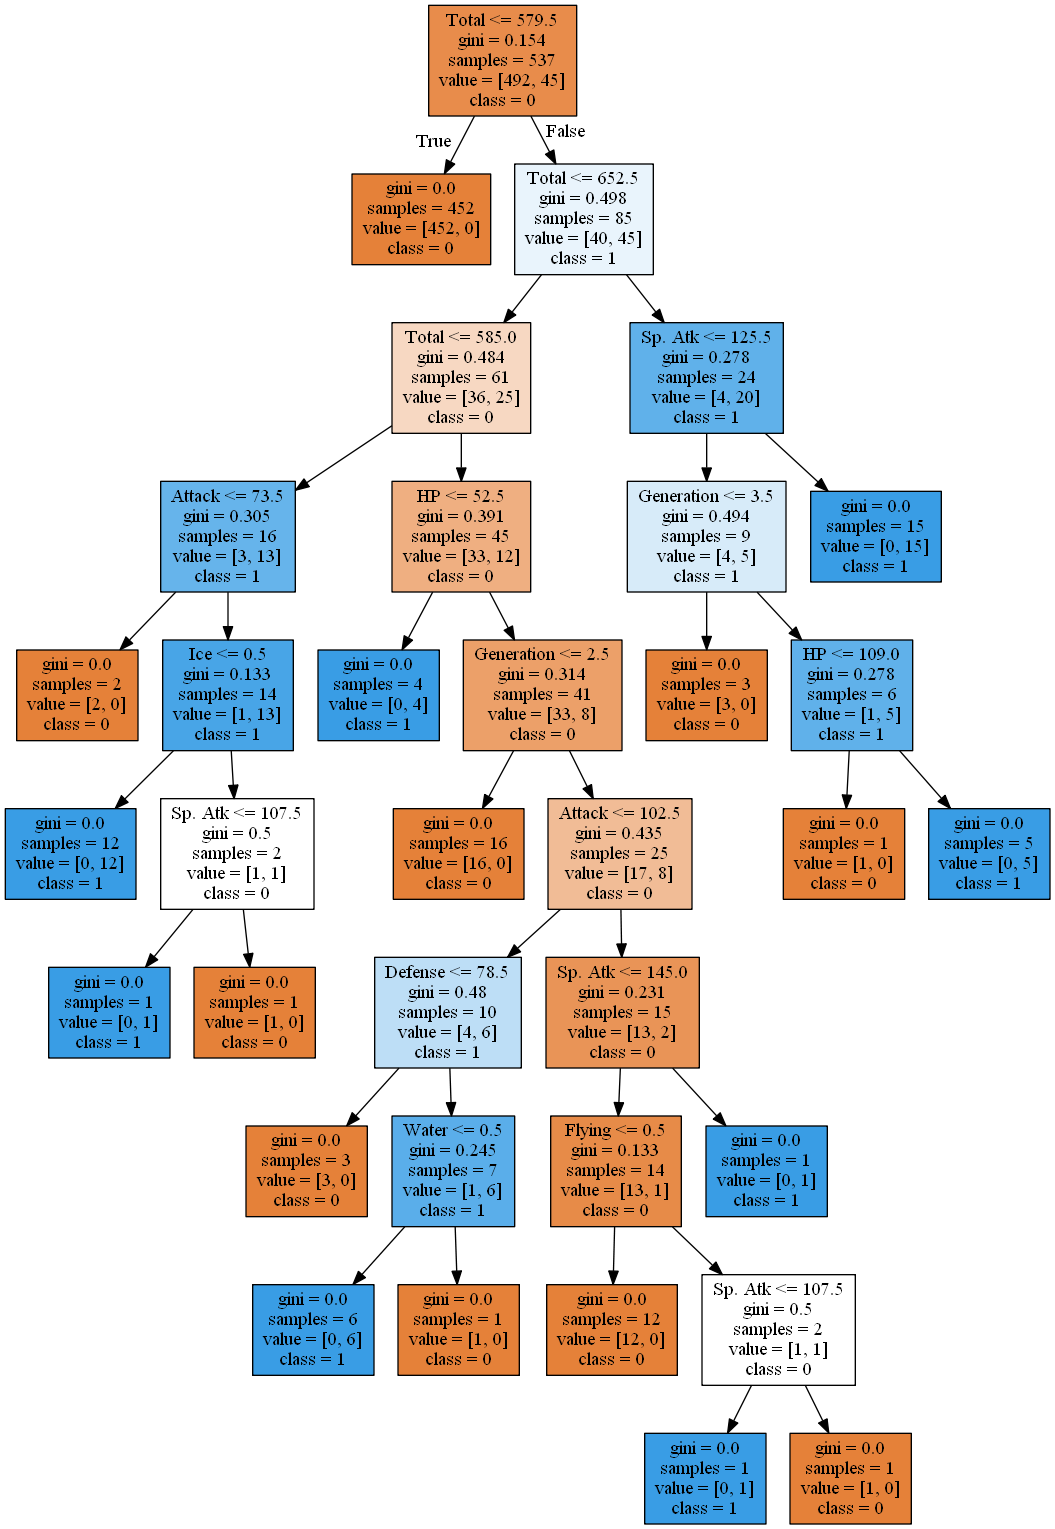

In [12]:
graph = Source( tree.export_graphviz(tree_clf_ext, out_file=None, feature_names=X_train.columns,class_names=['0', '1'],
                                    filled = True))
png_bytes = graph.pipe(format='png')
with open('second_tree.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

## Отобрать самые важные признаки случайным лесом, сравнить результат с отбором признаков линейным методом с L_1L -регуляризацией

In [13]:
def feat_coef(estimator):
    array = []
    for column,coef in zip(X_train.columns,estimator.feature_importances_):
        array.append((column,coef))
    array.sort(key = lambda x: x[1])  
    return array

In [19]:
ones = np.ones(len(X_test))
zeros = np.zeros(len(X_test))

score("Единичный классификатор:",ones)
score("Нулевой классификатор:",zeros)

Единичный классификатор: 0.07954545454545454
Нулевой классификатор: 0.9204545454545454


In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 1)
rnd_clf.fit(X_train,y_train)
print feat_coef(rnd_clf)

[('Grass', 0.0017044815144259399), ('Bug', 0.002118152525038994), ('Poison', 0.0024154612533525965), ('Ghost', 0.0024271288985452067), ('Ice', 0.0036741447434199006), ('Fighting', 0.00384751497912447), ('Electric', 0.004627862049783935), ('Dark', 0.004954767470098794), ('Rock', 0.005081001798872203), ('Normal', 0.005434915808016079), ('Fairy', 0.005762738235844196), ('Ground', 0.007408074320645314), ('Steel', 0.00801391393766465), ('Water', 0.008161971304284015), ('Flying', 0.0082340005856602), ('Fire', 0.009451752881345974), ('Dragon', 0.014267844669880878), ('No second type', 0.014629139234191018), ('Psychic', 0.017637110910463563), ('Generation', 0.03127383348670381), ('Defense', 0.051229043872092796), ('Attack', 0.08860696202588324), ('HP', 0.09078930824806714), ('Sp. Def', 0.10904128960854358), ('Sp. Atk', 0.12734229047794549), ('Speed', 0.13069910027099463), ('Total', 0.24116619488911126)]


L1_l:
* 4 признака с наибольшими по величине отрицательными коэффициентами {Normal,Bug,Poison,Attack}
* 4 признака с наибольшими по величине коэффициентами {Hp,Sp.Def,Speed,Total}
* признаки с нулевым значением коэффициента {Ice,Sp.Atk}


В предыдущей работе было уже отмечено,что при L1-регуляризации был отброшен значимый признак "Sp.Atk".Результаты полученные при использовании RandomForest и L2-регуляризации оказались точнее 

In [21]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
print "Качество RandomForest",accuracy_score(y_pred,y_test)

Качество RandomForest 0.9431818181818182


### Сравнить качество работы случайного леса без кросс-валидации с кросс-валидацией

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


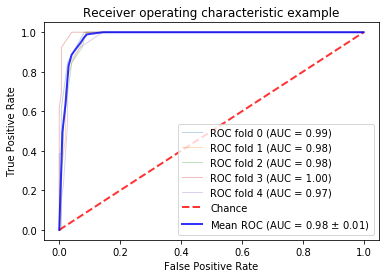

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = StratifiedKFold(n_splits=5, random_state=1)
clf = RandomForestClassifier(random_state = 1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

index = np.arange(0,len(raw_data),1)
raw_data["index"] = index
raw_data.set_index("index",inplace = True)

X = raw_data.iloc[:,:-1]
y = raw_data.Legendary
i = 0

for train, test in cv.split(X, y):
    probas_ = clf.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Сравнить качество работы и время обучения (%%time в начале ячейки) леса с градиентным бустингом над решающими деревьями,подобрав для каждого оптимальные параметры.

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
%%time
import xgboost as xgb

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = xgb.XGBClassifier(n_estimators=int(n_trees), max_depth=depth).fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Wall time: 5.36 s


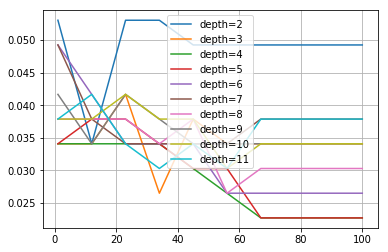

In [25]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for i in range(scores.shape[0]):
    plt.plot(np.linspace(1, 100, 10), scores[i], label='depth=' + str(np.arange(2, 12)[i]))
plt.grid(True)
plt.legend()

* глубина 5

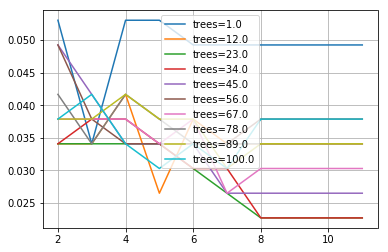

In [26]:
for i in range(scores.shape[1]):
    plt.plot(np.arange(2, 12), scores[i], label='trees=' + str(np.linspace(1, 100, 10)[i]))
plt.grid(True)
plt.legend()

* лучшее количество деревьев 34

In [27]:
%%time

from sklearn.ensemble import RandomForestClassifier

linear_preds = RandomForestClassifier().fit(X_train, y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.19462473604038075
Wall time: 24 ms
